# CHECK ATTACK (PERTURBED) FILES

In [1]:
import IPython.display as ipd
import logging
import numpy as np
import librosa
from src.audio_utils import read_audio
from src.utils import *
# from sp_utils import spectrogram_inversion, get_spectrogram_from_audio
# from attacks_utils import retrieve_single_cached_spec, load_spec_model, evaluate_spec, get_pred_class
from check_attacks_utils import check_attack

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True


In [2]:
seed_everything(1234)
set_gpu(-1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
plt.style.use('dark_background')
rate = 16000

GPU selected: 0 - NVIDIA GeForce RTX 3060


In [13]:
def compute_snr(file_number, perturbed_audio):
    clean_audio_path = f'FGSM_ResNet/FGSM_ResNet_dataset_0dot0/FGSM_ResNet_LA_E_{file_number}_0dot0.flac' 
    clean_audio, _ = librosa.load(clean_audio_path, sr=16000)
    noise = perturbed_audio - clean_audio
    signal_power = np.mean(clean_audio**2)
    noise_power = np.mean(noise**2) 
    snr = 10 * np.log10(signal_power/noise_power)
    if snr > 1e5:
        snr = 0
    return snr


    

def check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate):
    perturbed_audio, original_audio, perturbed_spec, original_spec = check_attack(eval_model=eval_model, 
                                                                 attack_model=attack_model, 
                                                                 attack=attack, 
                                                                 file_number=file_number, 
                                                                 epsilon=epsilon, 
                                                                 device=device)
    print(f'SNR: {compute_snr(file_number, perturbed_audio):.2f} dB')
    
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    librosa.display.specshow(original_spec, sr=rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Original signal for file {file_number}')
    plt.subplot(2,1,2)
    librosa.display.specshow(perturbed_spec, sr=rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Perturbed signal with {attack} attack on {attack_model} eps={epsilon}')
    plt.tight_layout()
    plt.show()
    
    return perturbed_audio, original_audio
    

--> File name: FGSM_ResNet_LA_E_1000147_0dot0.flac
--> Model evaluated: ResNet
--> Attack: FGSM on ResNet
--> Epsilon: 0.0
--> GT label: 1
 --> Predicted label: 1, 
tensor([[-2.4596, -0.0893]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
--> Confidence: 91.45 %
SNR: 0.00 dB


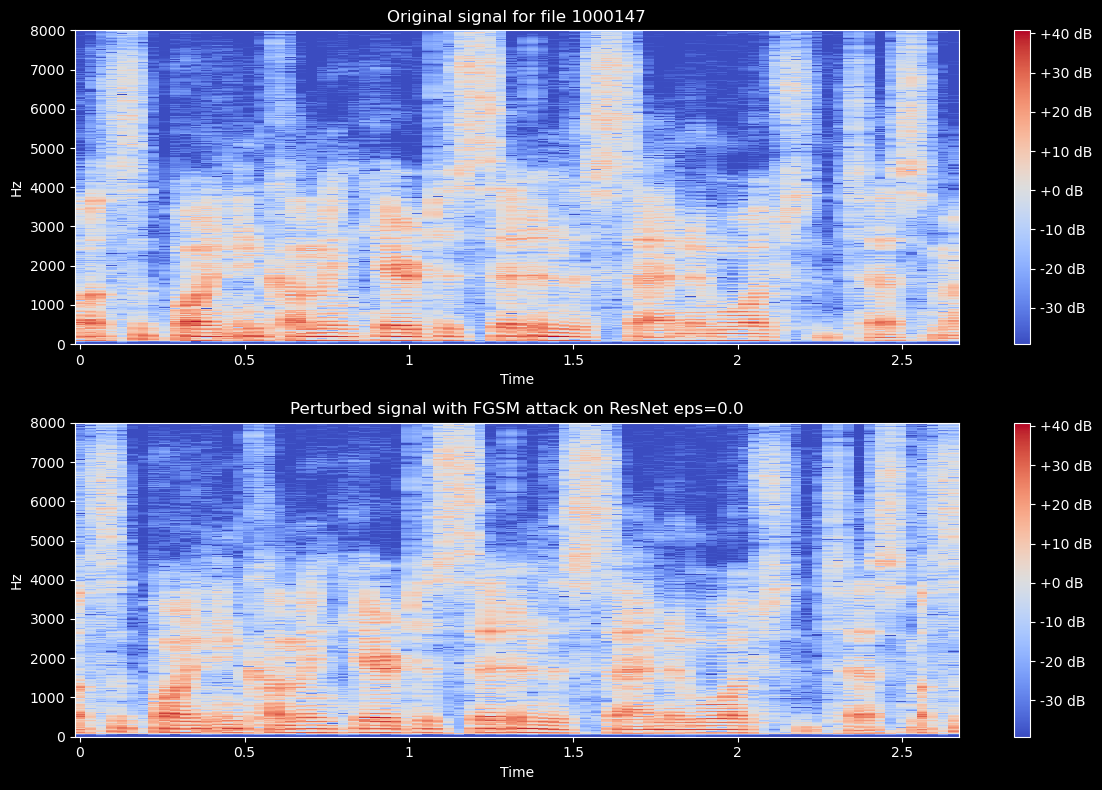

In [11]:
eval_model = 'ResNet'
attack_model = 'ResNet'
attack = 'FGSM'
file_number = 1000147
epsilon = 0.0
rate = 16000
perturbed_audioA, original_audioA = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate)

In [8]:
ipd.Audio(perturbed_audioA, rate=16000)

--> File name: FGSM_ResNet_LA_E_1000147_3dot0.flac
--> Model evaluated: ResNet
--> Attack: FGSM on ResNet
--> Epsilon: 3.0
--> GT label: 1
 --> Predicted label: 0, 
tensor([[-5.0543e-05, -9.8935e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
--> Confidence: 99.99 %
SNR: 13.55 dB


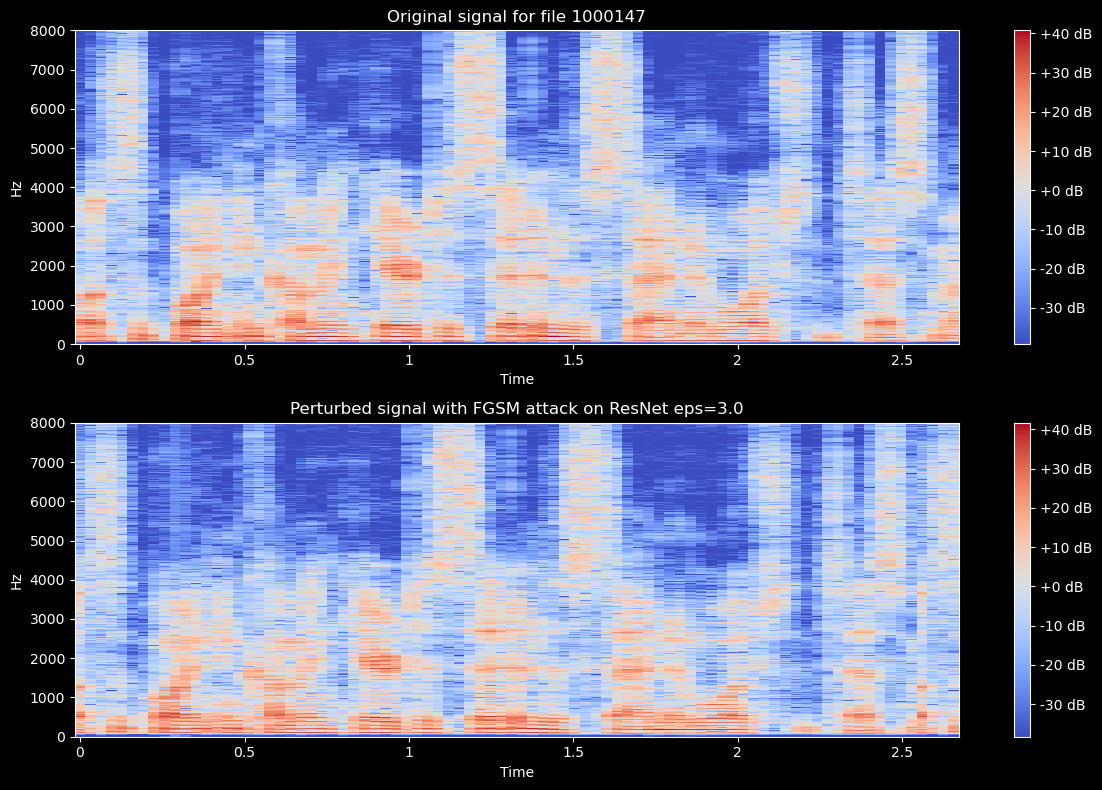

In [18]:
eval_model = 'ResNet'
attack_model = 'ResNet'
attack = 'FGSM'
file_number = 1000147
epsilon = 3.0
rate = 16000
perturbed_audioB, original_audioB = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate)

In [15]:
eval_model = 'LCNN'
attack_model = 'LCNN'
attack = 'FGSM_UNCUT'
file_number = 2834763
epsilon = 3.0
rate = 16000
perturbed_audioF, original_audioF = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate)

FileNotFoundError: [Errno 2] No such file or directory: 'FGSM_UNCUT_LCNN/FGSM_UNCUT_LCNN_dataset_3dot0/FGSM_UNCUT_LCNN_LA_E_2834763_3dot0.flac'

In [13]:
ipd.Audio(perturbed_audioF, rate=16000)

--> File name: FGSM_SENet_LA_E_2834763_2dot0.flac
--> Model evaluated: SENet
--> Attack: FGSM on SENet
--> Epsilon: 2.0
--> GT label: 1
 --> Predicted label: 1, 
tensor([[-1.4089, -0.2803]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
--> Confidence: 75.56 %
SNR: 18.16 dB


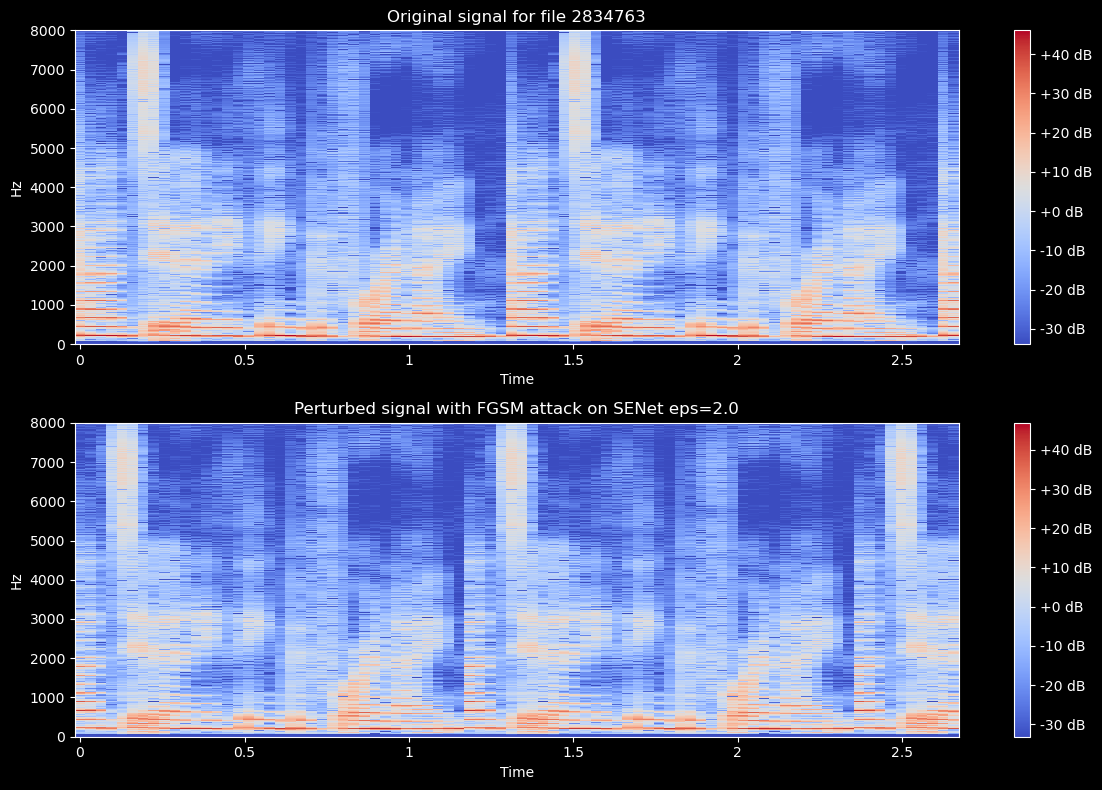

In [19]:
eval_model = 'SENet'
attack_model = 'SENet'
attack = 'FGSM'
file_number = 2834763
epsilon = 2.0
rate = 16000
perturbed_audioB, original_audioB = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate)

--> File name: FGSM_LCNN_LA_E_2834763_2dot0.flac
--> Model evaluated: LCNN
--> Attack: FGSM on LCNN
--> Epsilon: 2.0
--> GT label: 1
 --> Predicted label: 0, 
tensor([[-7.9390e-05, -9.4407e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
--> Confidence: 99.99 %
SNR: 18.32 dB


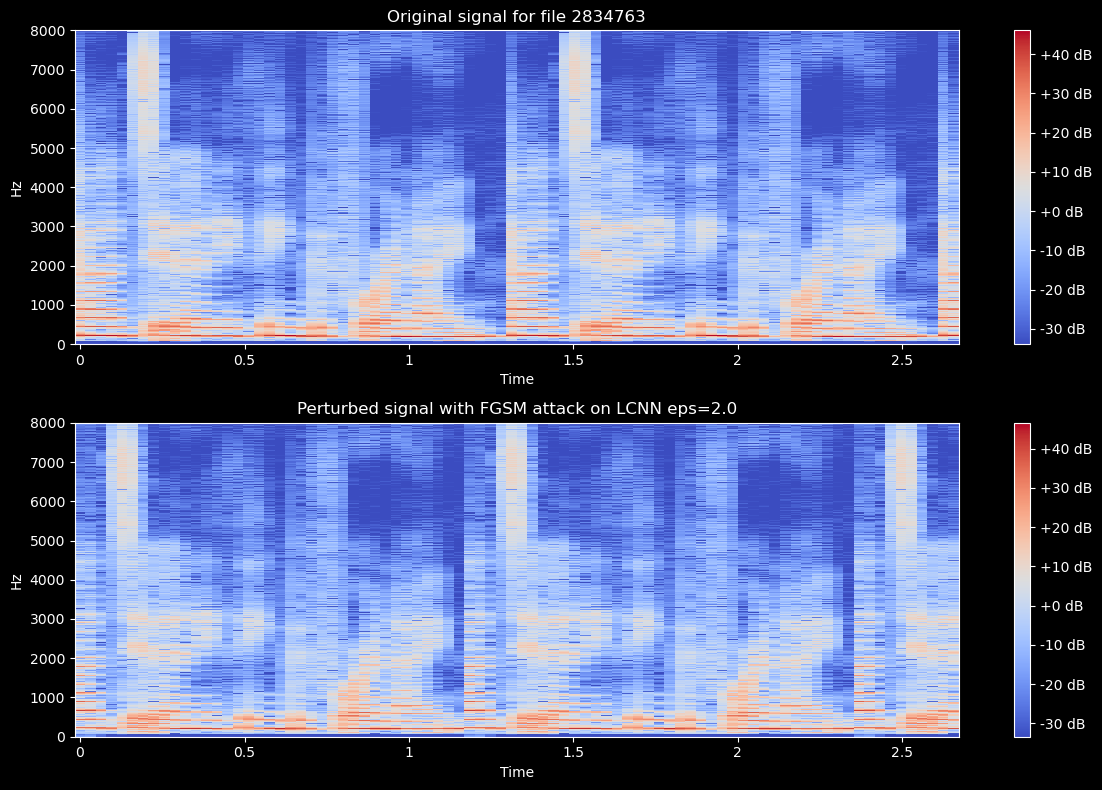

In [20]:
eval_model = 'LCNN'
attack_model = 'LCNN'
attack = 'FGSM'
file_number = 2834763
epsilon = 2.0
rate = 16000
perturbed_audioC, original_audioC = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate)